In [1]:
import pandas as pd
from pandas_datareader import data
import numpy as np
from datetime import datetime
from datetime import timedelta
import re
import math
import statsmodels.api as sm
import seaborn as sns
from matplotlib import pyplot as plt
plt.style.use('ggplot')

In [22]:
with open('tickers.txt','r') as file:
    tickers = file.readlines()
    
tickers = [item.strip() for item in tickers]

In [8]:
columns = ['transaction_date', 'transaction_type', 'company_name',
           'ticker', 'name', 'position', 'shares_traded', 'avg_price',
           'total_price', 'shares_owned', 'own_type']


In [81]:
def file_readr(ticker_list):
    my_dict = {}
    for ticker in ticker_list:
        try:
            current_df = pd.read_csv(f'./insiders_{ticker}.csv', header = None, names = columns)
            if current_df.shape[0] > 0:
                my_dict[ticker] = current_df
            else:
                continue
            del current_df
        except:
            continue
    
    return my_dict


In [82]:
dict_insiders = file_readr(tickers)



### cleaning insiders dictionary 

In [85]:

def clean_dict(x_dict):
    
    for ticker in x_dict.keys():
        df = x_dict[ticker]
    
        df.set_index(pd.to_datetime(df.transaction_date), inplace = True)
        
        print(f'{ticker}')

        df.drop('transaction_date',axis=1, inplace = True)
    
        transactions_list = [item.split('(')[0] for item in df.transaction_type.tolist()]
    
        df['sale_num'] = [1 if item == 'Sale' else 0 for item in transactions_list]
        df['buy_num'] = [1 if item == 'Purchase' else 0 for item in transactions_list]

        weekly = df.set_index(df.index-timedelta(days=7)).resample('W-SUN')
    
        shares_sum = weekly.shares_traded.sum()
        total_price = weekly.total_price.sum()
        insider_sell = weekly.sale_num.sum()
        insider_buy = weekly.buy_num.sum()
    
        left = pd.merge(shares_sum,total_price,on=shares_sum.index)
        right = pd.merge(insider_sell,insider_buy,on=insider_sell.index)

        left = left.set_index('key_0')
        right = right.set_index('key_0')

        agg = pd.merge(left,right,on=left.index)
        agg = agg.set_index('key_0')
        agg.index.name = 'Date'
    
        x_dict[ticker] = agg
        
        print('cleaned successfully')
    
    return x_dict
    

In [86]:
dict_insiders = clean_dict(dict_insiders)

FCX
cleaned successfully
MAS
cleaned successfully
HAS
cleaned successfully
AMZN
cleaned successfully
MU
cleaned successfully
VAR
cleaned successfully
PEG
cleaned successfully
LEG
cleaned successfully
JBHT
cleaned successfully
CAT
cleaned successfully
K
cleaned successfully
HES
cleaned successfully
NDAQ
cleaned successfully
BLL
cleaned successfully
AAP
cleaned successfully
VTR
cleaned successfully
LW
cleaned successfully
PG
cleaned successfully
NSC
cleaned successfully
PBCT
cleaned successfully
AMAT
cleaned successfully
MAR
cleaned successfully
INCY
cleaned successfully
ORLY
cleaned successfully
ROL
cleaned successfully
JWN
cleaned successfully
NEE
cleaned successfully
QRVO
cleaned successfully
CVX
cleaned successfully
HUM
cleaned successfully
NBL
cleaned successfully
BDX
cleaned successfully
AWK
cleaned successfully
SJM
cleaned successfully
PXD
cleaned successfully
CHD
cleaned successfully
AMP
cleaned successfully
DRI
cleaned successfully
AEE
cleaned successfully
ABMD
cleaned successfu

### cleaning stock price data

In [3]:
def get_stocks(x_dict):
    stocks_dict = {}
    
    for item in x_dict.keys():
        ticker = item
        start_date = str(x_dict[ticker].index[0]).split()[0]
        end_date = str(x_dict[ticker].index[-1]).split()[0]
        
        stocks_df = data.DataReader(ticker,'yahoo',start_date,end_date)
        
        stocks_dict[ticker]=stocks_df
        
    return stocks_dict
        
        

In [91]:
def clean_stocks(x_dict):    
    stocks_dict = {}
    
    for item in x_dict.keys():
        ticker = item
        stocks_df = x_dict[ticker]
        stocks_df['Return'] = stocks_df['Adj Close'].diff()
        stocks_df['Log_Return'] = [math.log(item) for item in stocks_df['Adj Close'].tolist()]
        stocks_df['Log_Return'] = stocks_df['Log_Return'].diff()
        
        stocks_df_weekly = stocks_df.set_index(stocks_df.index-timedelta(days=7)).resample('W-SUN').sum()[['Volume','Return','Log_Return']]
        
        stocks_dict[ticker]=stocks_df_weekly
        
    return stocks_dict

In [89]:
stocks_dict_pre = get_stocks(dict_insiders)

In [92]:
stocks_dict = clean_stocks(stocks_dict_pre)

77

#### merging and cleaning insider & stock data

In [12]:
def merge_dicts(x_dict,y_dict):
    full_dict = {}
    
    for item in x_dict.keys():
        ticker = item
        
        if ticker not in y_dict.keys():
            raise ValueError('Keys must match in both dictionaries.')
        else:
            
            left = x_dict[ticker]
            right = y_dict[ticker]
            
            full_df = pd.merge(left,right, on=left.index)
            full_df = full_df.set_index('key_0')
            full_df.index.name = 'Date'
            
            full_df.sale_num[full_df.sale_num > 0] = 1
            full_df.buy_num[full_df.buy_num>0] = 1
            full_df['return_dummy'] = full_df.Log_Return
            full_df.return_dummy[full_df.return_dummy<0]=0
            full_df.return_dummy[full_df.return_dummy>0]=1
        
            full_dict[ticker]=full_df
            
    return full_dict
        
        
        

In [13]:
full_dict = merge_dicts(dict_insiders,stocks_dict)

/Users/mdrozdov/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/mdrozdov/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/mdrozdov/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/mdrozdov/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is tr

### plotting insider trades

In [102]:

def plot_dict(insider_dict,stocks_dict):
    plt.style.use('bmh')
    fig = plt.figure(figsize=(20,15))
    
    for item in insider_dict.keys():
        
        ticker = item
        
        if ticker not in stocks_dict.keys():
            
            raise ValueError('Keys must match in both dictionaries')
            
        else:
            
            stock_df = stocks_dict[ticker]
            insider_df = insider_dict[ticker]
            
            sns.lineplot(x=stock_df.index,y=stock_df['Adj Close'])
            for x in insider_df.index.tolist():
                plt.axvline(x,linestyle=':',linewidth=0.1,c='b')
                    
        

In [145]:
# sale_buy_dict = {'sell':sum(dict_insiders['CERN'].sale_num.tolist()),'buy':sum(dict_insiders['CERN'].buy_num.tolist())}

# sell_buy_df = pd.DataFrame([sale_buy_dict])

# sells = dict_insiders['CERN'][['sale_num','buy_num']].agg(sum)['sale_num']
# buys = dict_insiders['CERN'][['sale_num','buy_num']].agg(sum)['buy_num']
# ticker = 'CERN'

# sell_buy_dict = {'ticker':ticker,'sells':sells,'buys':buys}

# sell_buy_df = pd.DataFrame()
# sell_buy_df.append([sell_buy_dict])



,buys,sells,ticker
0,4,234,CERN


In [138]:
# def plot_bar_dict(dict_insiders):
# #     plt.style.use('bmh')
# #     fig = plt.figure(figsize=(20,15))
    
#     sell_buy_df = pd.DataFrame()
    
#     for item in dict_insiders.keys():
        
#         ticker = item
        
#         df = dict_insiders[ticker]
        
#         sells = df[['sale_num','buy_num']].agg(sum)['sale_num']
#         buys = df[['sale_num','buy_num']].agg(sum)['buy_num']
#         sell_buy_dict = {'ticker':ticker,'sells':sells,'buys':buys}
        
#         sell_buy_df.append([sell_buy_dict])
    
#     return sell_buy_df
        
        

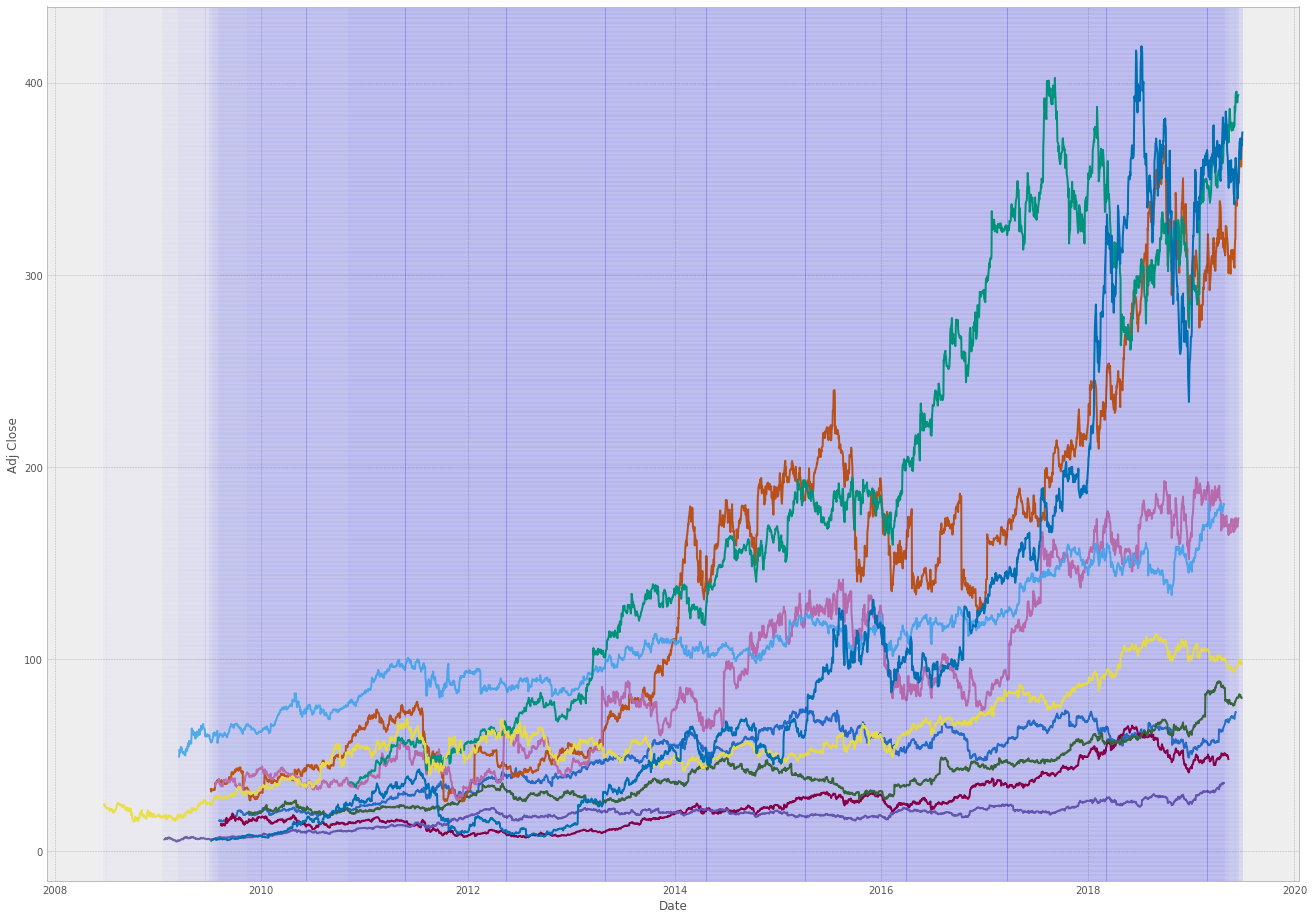

In [103]:
plot_dict(dict_insiders,stocks_dict_pre)

### fitting logistic models

In [66]:
def logit_dict(x_dict):
    fit_dict = {}
    
    for item in x_dict.keys():
        
        ticker = item
        print(ticker)
        df = x_dict[ticker]
        
        X = df[['shares_traded','sale_num','buy_num']]
        Y = df.return_dummy
        logit_model = sm.Logit(Y,X)
        result = logit_model.fit()
        
        fit_dict[ticker]=result
        
        
    return fit_dict

In [ ]:
sm.Logit().get

In [67]:
models_dict = logit_dict(full_dict)


CERN
Optimization terminated successfully.
         Current function value: 0.690904
         Iterations 4
ETFC
Optimization terminated successfully.
         Current function value: 0.689647
         Iterations 6
FAST
Optimization terminated successfully.
         Current function value: 0.683172
         Iterations 4
GRMN
         Current function value: 0.688239
         Iterations: 35
ILMN
Optimization terminated successfully.
         Current function value: 0.682538
         Iterations 20
VRTX
Optimization terminated successfully.
         Current function value: 0.688043
         Iterations 5
WLTW
Optimization terminated successfully.
         Current function value: 0.687934
         Iterations 5
CHTR
Optimization terminated successfully.
         Current function value: 0.689260
         Iterations 6
CTXS
Optimization terminated successfully.
         Current function value: 0.689543
         Iterations 4
NFLX
Optimization terminated successfully.
         Current function val

/Users/mdrozdov/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [72]:
for key,value in models_dict.items():
    print(key)
    print('-'*30)
    print(value.pvalues)
    print('*'*30)



CERN
------------------------------
shares_traded    0.574733
sale_num         0.470404
buy_num          0.607995
dtype: float64
******************************
ETFC
------------------------------
shares_traded    0.276215
sale_num         0.948917
buy_num          0.236157
dtype: float64
******************************
FAST
------------------------------
shares_traded    0.873156
sale_num         0.115237
buy_num          0.010173
dtype: float64
******************************
GRMN
------------------------------
shares_traded    0.448641
sale_num         0.262504
buy_num          0.999794
dtype: float64
******************************
ILMN
------------------------------
shares_traded    0.318228
sale_num         0.194082
buy_num          0.999999
dtype: float64
******************************
VRTX
------------------------------
shares_traded    0.066277
sale_num         0.264957
buy_num          0.400235
dtype: float64
******************************
WLTW
------------------------------
shar